<a href="https://colab.research.google.com/github/bgalerne/mva_generative_models_for_images/blob/main/1_mvagm_gaussian_textures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stationary Gaussian processes for texture synthesis

#Set up and downlaod some texture images

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.color

import imageio

from IPython.display import display
from PIL import Image
import os

Feel free to use other micro-textures.

(768, 512)


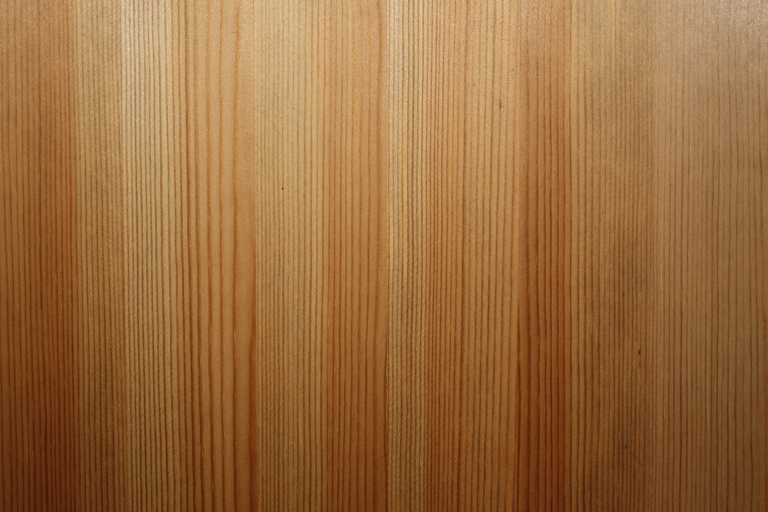

(768, 512)


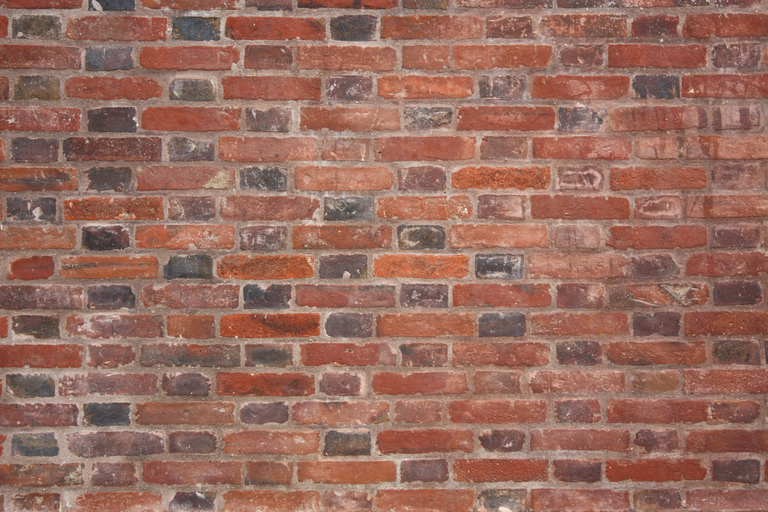

(768, 512)


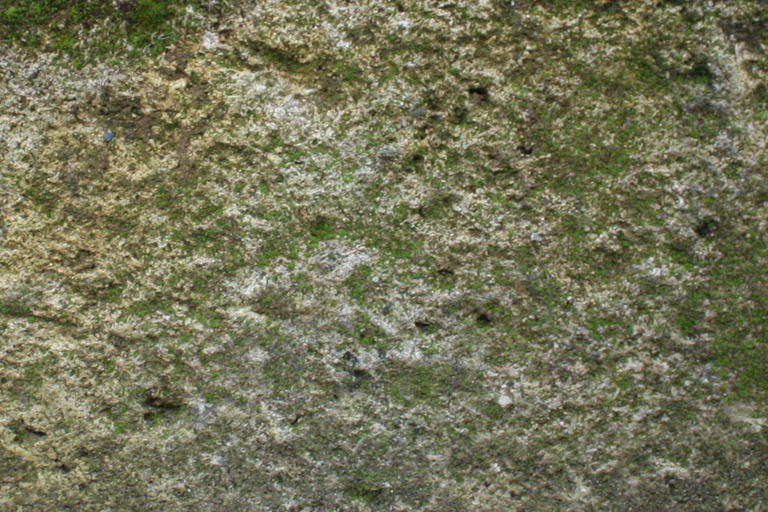

(360, 360)


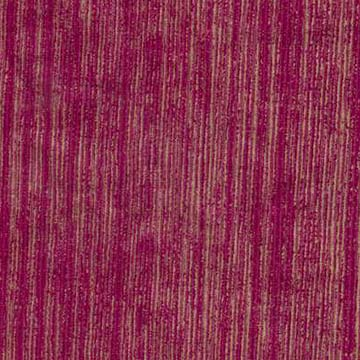

(768, 512)


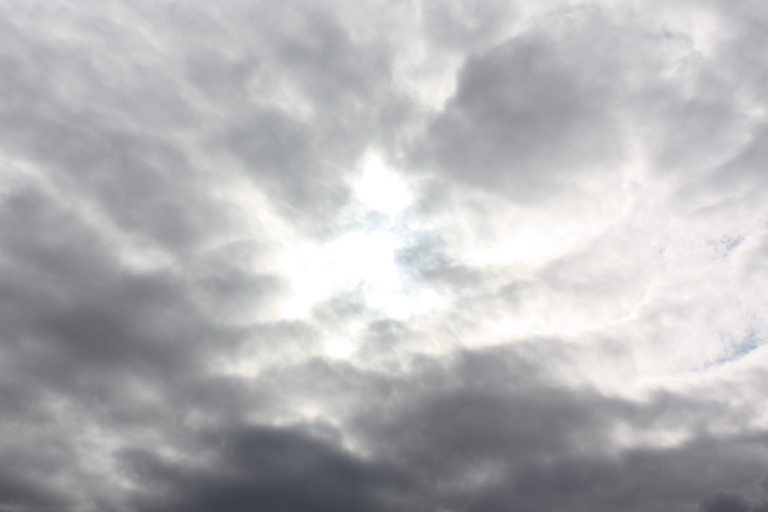

In [13]:
texture_imgnames = ["bois.png", "briques.png", "mur.png", "tissu.png", "nuages.png"]
#import wget
for fname in texture_imgnames:
  os.system("wget -c https://www.idpoisson.fr/galerne/mva/"+fname)
  img = Image.open(fname)
  print(img.size)
  display(img)

#Discrete Fourier transform

##Visualization of Discrete Fourier transform

The code below displays an image, and its Fourier transform:
- real part
- imaginary part
- modulus (in log scale)
- phase

In [ ]:
imgrgb = skimage.img_as_float(imageio.imread('tissu.png'))
imggray = skimage.color.rgb2gray(imgrgb)
dftimg = np.fft.fftshift(np.fft.fft2(imggray))
moddft = np.abs(dftimg)
phase = np.angle(dftimg)
rec = np.fft.ifft2(np.fft.ifftshift(dftimg))
print('max imaginary part: ', np.max(np.abs(np.imag(rec))))
rec = np.real(rec) # set imaginary part to zero

fig, ax = plt.subplots(2, 3, figsize=(30, 20))
im = ax[0,0].imshow(imggray, cmap=plt.cm.gray)
im.set_clim(0,1)
ax[0,0].set_title("Grayscale image")

im = ax[0,1].imshow(np.real(dftimg), cmap=plt.cm.gray)
ax[0,1].set_title("Real part")
im = ax[0,2].imshow(np.imag(dftimg), cmap=plt.cm.gray)
ax[0,2].set_title("Imag. part")

im = ax[1,0].imshow(rec, cmap=plt.cm.gray)
im.set_clim(0,1)
ax[1,0].set_title("Rec. image")

im = ax[1,1].imshow(np.log(1+moddft), cmap=plt.cm.gray) # log scale for contrast
ax[1,1].set_title("Modulus")

im = ax[1,2].imshow(phase, cmap=plt.cm.gray)
ax[1,2].set_title("Modulus")


fig.tight_layout()
plt.show()



#DFT fo RGB images
The DFT of an RGB image corresponds to the DFT of each channel. This can be computed directly in specifying to ```np.fft.fft2``` to compute the FFT along the 2 first variables. Still it may be safer to use loops on channels in your code...


In [37]:

imgrgb = skimage.img_as_float(imageio.imread('tissu.png'))
dftimgrgbwrong = np.fft.fftshift(np.fft.fft2(imgrgb))
dftimgrgb = np.fft.fftshift(np.fft.fft2(imgrgb, axes=(0,1)), axes=(0,1)) # axes for both fft2 and fftshift

# compare with DFT of extracted chanel:
c = 1
single_chanel = imgrgb[:,:,c]
dftsg = np.fft.fftshift(np.fft.fft2(single_chanel))
print("No axes given:", np.allclose(dftimgrgbwrong[:,:,c], dftsg))
print("Axes given:", np.allclose(dftimgrgb[:,:,c], dftsg))


No axes given: False
Axes given: True


# ADSN for texture synthesis


**Recalls from the course:** 

Let $h\in\mathbb{R}^{M\times N}$ be a an image, $m$ be the mean of $h$ and $X$ be a Gaussian white noise image.
The random image
$$
\frac{1}{\sqrt{MN}}\left(h - m\right) \ast X
$$
is the {\em ADSN} associated with $h$.

This generalizes to **RGB color images** by
$$
Y = \frac{1}{\sqrt{MN}}
\begin{pmatrix}
\left( h_r - m_r \right) \ast X\\
\left( h_g - m_g \right) \ast X\\
\left( h_b - m_b \right) \ast X
\end{pmatrix},~~~X~\text{a Gaussian white noise.}
$$




### Exercise 1:

1. Define a function ```adsn(h)``` that simulates a realization of the model $ADSN(h)$ for a grayscale image $h$
2. Define a function ```adsnrgb(h)``` that simulates a realization of the model $ADSN(h)$ for an RGB image.
3. Test this function on the provided textures and discuss the quality of the result. 


In [ ]:
# TODO

Discussion here

#Periodic component of an image
**Recalls from the course:** 

*Periodic Poisson problem:* 

Find the image $p$ such that
\begin{equation*}
\begin{cases}
\Delta p = \Delta_i h\\
\operatorname{mean}(p) = \operatorname{mean}(h)
\end{cases}
\end{equation*}
where, noting $N_x$ the neighborhood of $x\in\Omega$ for 4-connexity:
$$
\Delta f(x) = 4 f(x) - \sum_{y\in N_x} f(y)
\quad \text{and} \quad
\Delta_i f(x) = \left|N_x\cap\Omega\right| f(x) - \sum_{y\in N_x\cap\Omega} f(y).
$$

In the *Fourier domain*, this system becomes:
\begin{equation*}
\begin{cases}
\left(4 - 2\cos\left( \frac{2 s \pi}{M} \right) - 2\cos\left( \frac{2 t \pi}{N} \right) \right) \hat{p}(s,t)
= \widehat{\Delta_i h}(s,t),
~(s,t)\in\hat{\Omega}\setminus\{(0,0)\},\\
\hat{p}(0,0) = \operatorname{mean}(h).
\end{cases}
\end{equation*}

**Algorithm to compute the periodic component:**

1. Compute $\Delta_i h$ the discrete Laplacian of $h$.
1. Compute $m=\operatorname{mean}(h)$.
1. Compute $\widehat{\Delta_i h}$ the DFT of $\Delta_i h$ using the forward FFT.
1. Compute the DFT $\hat{p}$ of $p$ defined by
\begin{equation*}
\begin{cases}
\hat{p}(s,t) =
\frac{\widehat{\Delta_i h}((s,t))}{- 4 + 2\cos\left( \frac{2 s \pi}{M} \right) + 2\cos\left( \frac{2 t \pi}{N} \right)}
& \text{for $(s,t)\in\hat{\Omega}\setminus\{(0,0)\}$}\\
\hat{p}(0,0) = m & \\
\end{cases}
\end{equation*}
1. Compute $p$ using the backward FFT (if necessary).


### Exercise 2:
1. Show on paper that the two systems are equivalent.
2. Implement a function periodic_component(h) that computes the periodic component of a grayscale image.
3. For the image ```nuages.png```visualize the image, its periodic component, and the Fourier modulus of both images. Also check visually that the periodic component is tileable (use ```np.tile```).
3. Compare the results of using an original image VS. its periodic component to define an ADSN.

In [ ]:
#TODO

#Texton and larger textures

In this section we only consider grayscale images.

**Recalls from the course:** 

The *texton* $t_h$ associated with $h$ is the image with the same modulus as $h$ and with zero phase.

###Exercise 3:
1. Write a function ```texton(h)``` that computes that texton associated to the image $h$. Visualize the result.
2. Write a function ```extended_adsn(h,r)``` that produces an ADSN image with size $r$ times larger. This is obtained as the ADSN associated to the image
$$
\tilde{t}_h = m + r (t_h - m)\mathbf{1}_\Omega
$$
where $\Omega$ is the smaller initial domain. Ilustrate the results.




In [ ]:
#TODO